In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from datetime import datetime
from google.colab import files

In [2]:

# Set random seed to ensure reproducible results
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Load and preprocess data
print("Loading data...")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

Loading data...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [28]:
# Define 10 experiment configurations
configs = [
    # Configuration 1: Baseline configuration
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'baseline'},

    # Configuration 2-4: Optimizer variations
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'rmsprop',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'sgd',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'nadam',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer'},

    # Configuration 5-6: Learning rate variations
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.01, 'experiment_group': 'learning_rate'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.0001, 'experiment_group': 'learning_rate'},

    # Configuration 7-8: Network width variations
    {'filters': 32, 'kernel_size': 5, 'dense_units': 64, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width'},
    {'filters': 128, 'kernel_size': 5, 'dense_units': 256, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width'},

    # Configuration 9-10: Batch size variations
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 32, 'learning_rate': 0.001, 'experiment_group': 'batch_size'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 128, 'learning_rate': 0.001, 'experiment_group': 'batch_size'},
]

In [29]:
# Add epochs parameter for each configuration
for cfg in configs:
    cfg['epochs'] = 5  # All configurations use the same number of training epochs

# Print experiment plan
print(f"A total of {len(configs)} configurations will be tested:")
for i, cfg in enumerate(configs):
    print(f"{i+1}. Group: {cfg['experiment_group']} - {cfg}")

A total of 10 configurations will be tested:
1. Group: baseline - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'baseline', 'epochs': 5}
2. Group: optimizer - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'rmsprop', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
3. Group: optimizer - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'sgd', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
4. Group: optimizer - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'nadam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
5. Group: learning_rate - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.01, 'experiment_group': 'learning_rate', 'epochs': 5}
6. Group: learning_rat

In [25]:
# Training function
def train_model(config, x_train, y_train, x_test, y_test):
    model = models.Sequential([
        layers.Input(shape=x_train.shape[1:]),
        layers.Conv2D(config['filters'], (config['kernel_size'], config['kernel_size']),
                     activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(config['dense_units'], activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    # Set optimizer
    if config['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=config['learning_rate'])
    else:
        raise ValueError(f"Unsupported optimizer: {config['optimizer']}")

    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    print(f"\nTraining configuration: {config}")

    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_split=0.1,
        verbose=1
    )
    end_time = time.time()
    duration = round(end_time - start_time, 2)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    return {
        'config': config,
        'test_accuracy': test_acc,
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'training_time_sec': duration,
        'history': history.history
    }


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'baseline', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 87s 100ms/step - accuracy: 0.8037 - loss: 0.5504 - val_accuracy: 0.8758 - val_loss: 0.3404
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 78s 92ms/step - accuracy: 0.8956 - loss: 0.2878 - val_accuracy: 0.8957 - val_loss: 0.2926
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.9144 - loss: 0.2347 - val_accuracy: 0.9038 - val_loss: 0.2726
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 92ms/step - accuracy: 0.9281 - loss: 0.1968 - val_accuracy: 0.9070 - val_loss: 0.2676
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 79s 93ms/step - accuracy: 0.9403 - loss: 0.1650 - val_accuracy: 0.9118 - val_loss: 0.2619
Test accuracy: 0.9069


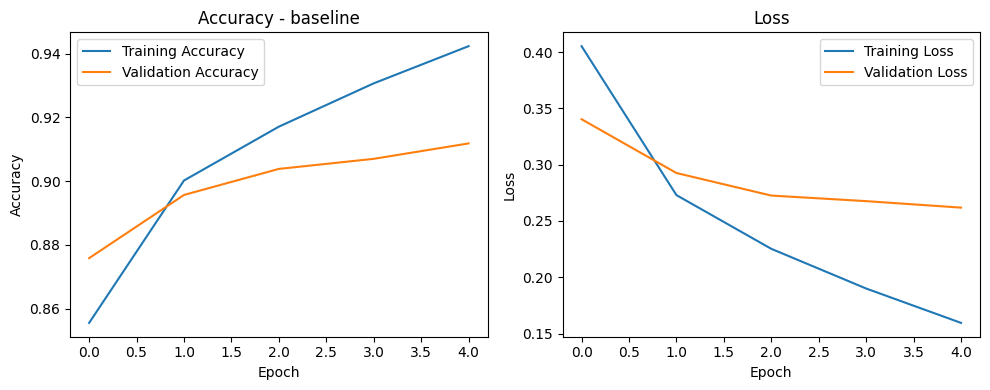


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'rmsprop', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 78s 91ms/step - accuracy: 0.7886 - loss: 0.5881 - val_accuracy: 0.8908 - val_loss: 0.3056
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.8948 - loss: 0.2910 - val_accuracy: 0.9043 - val_loss: 0.2667
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 86ms/step - accuracy: 0.9149 - loss: 0.2362 - val_accuracy: 0.9090 - val_loss: 0.2533
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 86s 90ms/step - accuracy: 0.9280 - loss: 0.1988 - val_accuracy: 0.9127 - val_loss: 0.2473
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accuracy: 0.9400 - loss: 0.1671 - val_accuracy: 0.9147 - val_loss: 0.2520
Test accuracy: 0.9120


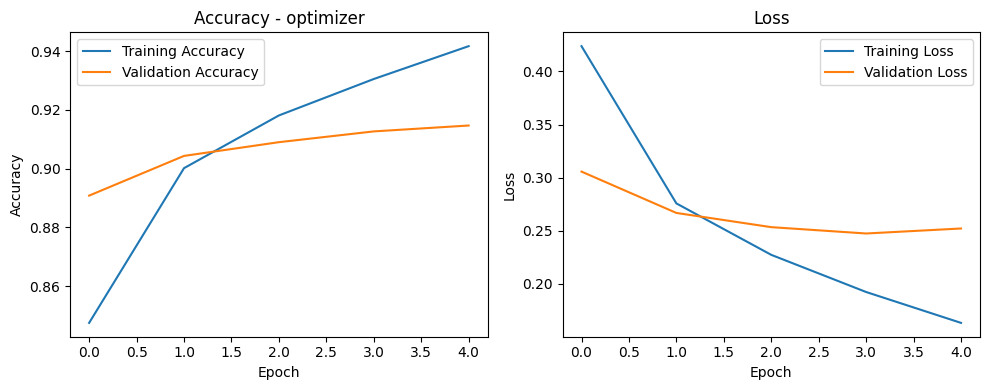


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'sgd', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.3011 - loss: 2.0990 - val_accuracy: 0.6655 - val_loss: 1.2180
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 71s 84ms/step - accuracy: 0.6792 - loss: 1.0662 - val_accuracy: 0.7415 - val_loss: 0.7863
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 86ms/step - accuracy: 0.7455 - loss: 0.7692 - val_accuracy: 0.7640 - val_loss: 0.6805
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - accuracy: 0.7715 - loss: 0.6792 - val_accuracy: 0.7800 - val_loss: 0.6279
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 73s 86ms/step - accuracy: 0.7856 - loss: 0.6306 - val_accuracy: 0.7943 - val_loss: 0.5945
Test accuracy: 0.7855


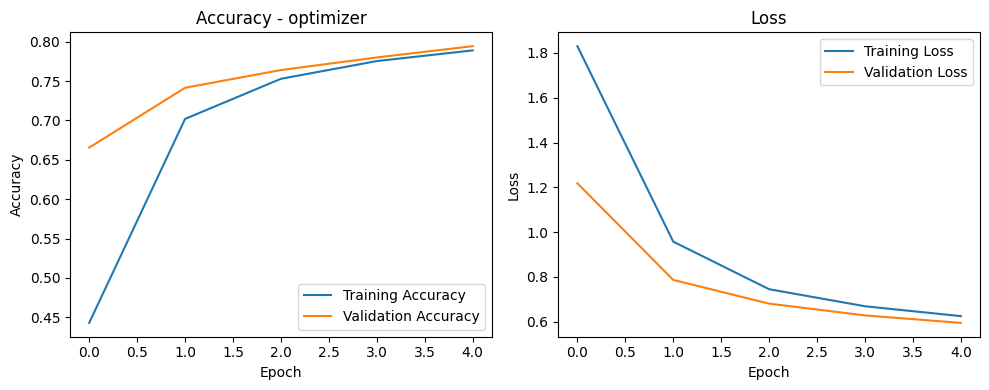


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'nadam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - accuracy: 0.8084 - loss: 0.5463 - val_accuracy: 0.8910 - val_loss: 0.3046
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.8984 - loss: 0.2820 - val_accuracy: 0.9060 - val_loss: 0.2681
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 90s 106ms/step - accuracy: 0.9176 - loss: 0.2292 - val_accuracy: 0.9112 - val_loss: 0.2578
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9325 - loss: 0.1905 - val_accuracy: 0.9140 - val_loss: 0.2562
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9442 - loss: 0.1572 - val_accuracy: 0.9127 - val_loss: 0.2636
Test accuracy: 0.9110


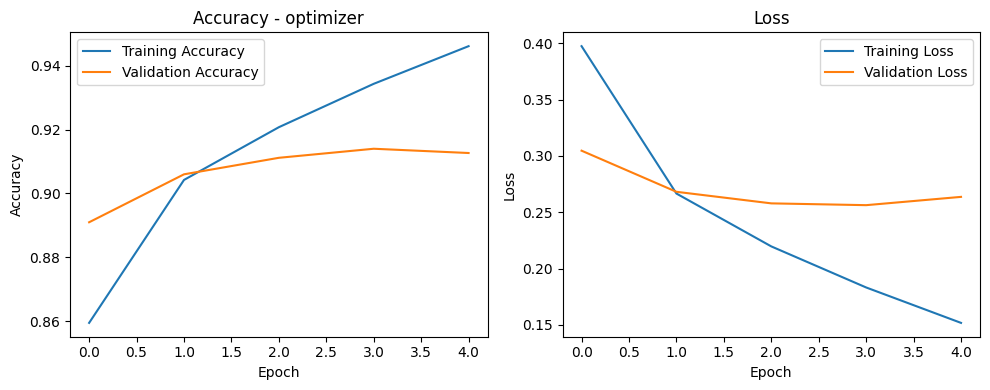


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.01, 'experiment_group': 'learning_rate', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 77s 89ms/step - accuracy: 0.8107 - loss: 0.5830 - val_accuracy: 0.8698 - val_loss: 0.3556
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.8920 - loss: 0.2986 - val_accuracy: 0.8863 - val_loss: 0.3144
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.9072 - loss: 0.2532 - val_accuracy: 0.8840 - val_loss: 0.3366
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.9122 - loss: 0.2312 - val_accuracy: 0.8808 - val_loss: 0.4069
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.9217 - loss: 0.2112 - val_accuracy: 0.8858 - val_loss: 0.4004
Test accuracy: 0.8856


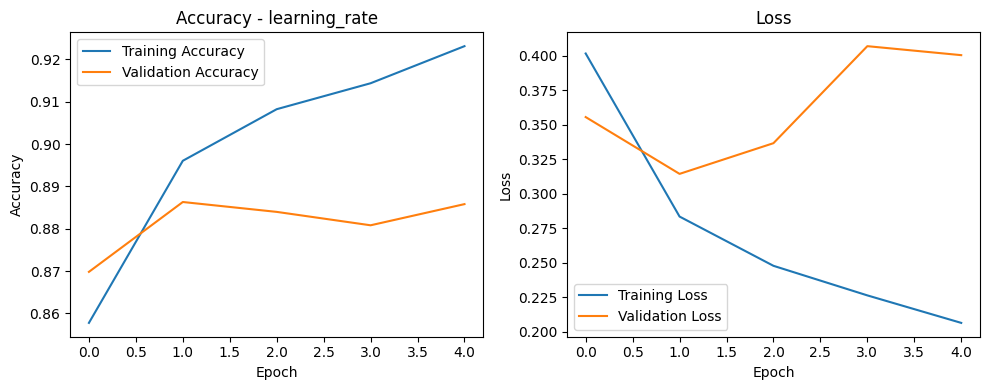


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.0001, 'experiment_group': 'learning_rate', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - accuracy: 0.7313 - loss: 0.8513 - val_accuracy: 0.8440 - val_loss: 0.4498
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 78s 93ms/step - accuracy: 0.8584 - loss: 0.4121 - val_accuracy: 0.8610 - val_loss: 0.3881
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 86s 98ms/step - accuracy: 0.8742 - loss: 0.3636 - val_accuracy: 0.8728 - val_loss: 0.3526
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 139s 94ms/step - accuracy: 0.8826 - loss: 0.3337 - val_accuracy: 0.8823 - val_loss: 0.3290
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.8908 - loss: 0.3119 - val_accuracy: 0.8885 - val_loss: 0.3127
Test accuracy: 0.8847


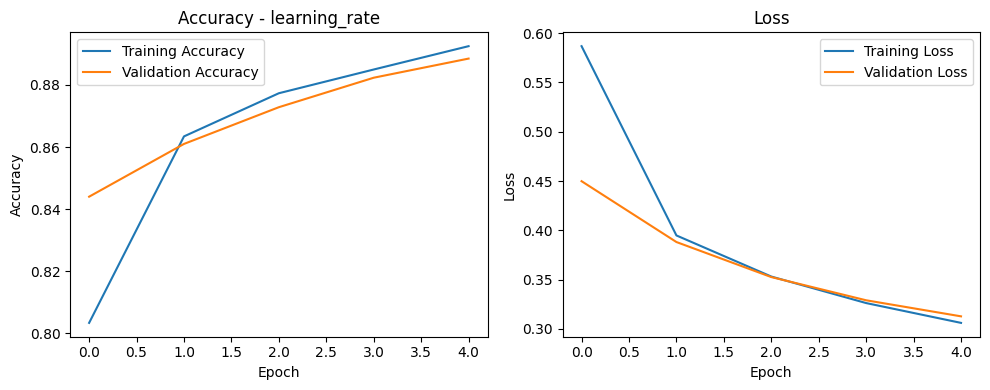


Training configuration: {'filters': 32, 'kernel_size': 5, 'dense_units': 64, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 47s 54ms/step - accuracy: 0.7868 - loss: 0.6243 - val_accuracy: 0.8695 - val_loss: 0.3663
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 85s 58ms/step - accuracy: 0.8882 - loss: 0.3167 - val_accuracy: 0.8860 - val_loss: 0.3192
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - accuracy: 0.9038 - loss: 0.2654 - val_accuracy: 0.8955 - val_loss: 0.2957
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - accuracy: 0.9173 - loss: 0.2294 - val_accuracy: 0.9025 - val_loss: 0.2781
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - accuracy: 0.9267 - loss: 0.1998 - val_accuracy: 0.9047 - val_loss: 0.2663
Test accuracy: 0.9046


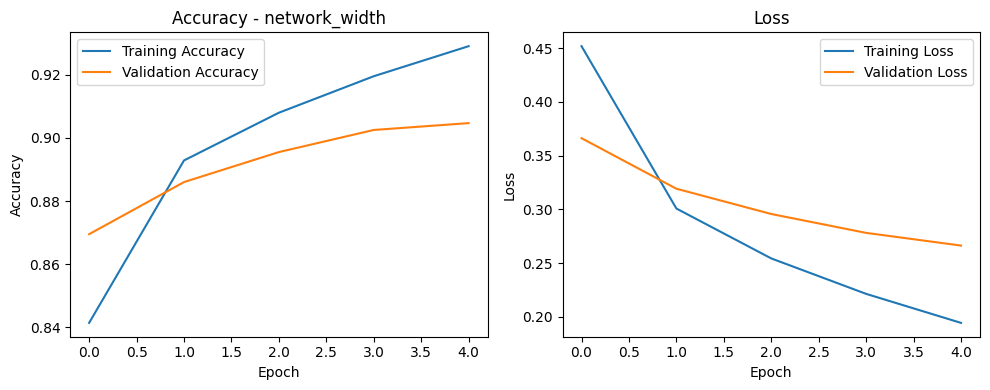


Training configuration: {'filters': 128, 'kernel_size': 5, 'dense_units': 256, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 178s 209ms/step - accuracy: 0.8221 - loss: 0.4897 - val_accuracy: 0.8833 - val_loss: 0.3199
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 172s 203ms/step - accuracy: 0.9048 - loss: 0.2635 - val_accuracy: 0.8992 - val_loss: 0.2879
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 175s 208ms/step - accuracy: 0.9266 - loss: 0.2025 - val_accuracy: 0.9075 - val_loss: 0.2665
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 172s 204ms/step - accuracy: 0.9433 - loss: 0.1585 - val_accuracy: 0.9093 - val_loss: 0.2692
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 206s 209ms/step - accuracy: 0.9565 - loss: 0.1211 - val_accuracy: 0.9153 - val_loss: 0.2753
Test accuracy: 0.9097


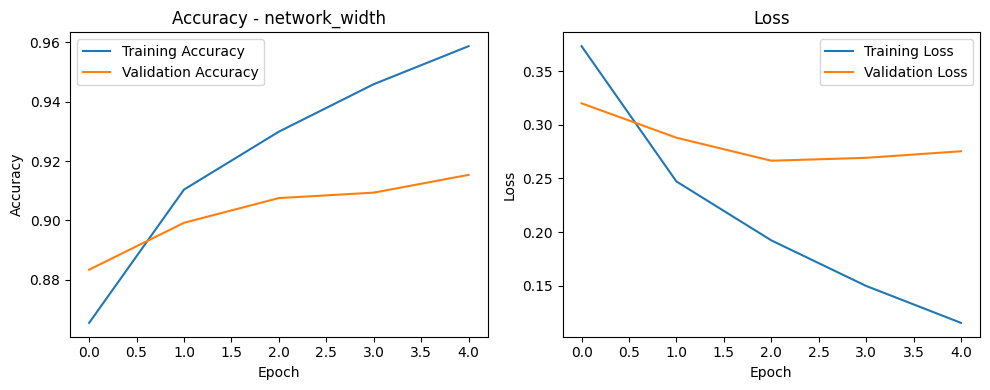


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 32, 'learning_rate': 0.001, 'experiment_group': 'batch_size', 'epochs': 5}
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 109s 63ms/step - accuracy: 0.8183 - loss: 0.5033 - val_accuracy: 0.8905 - val_loss: 0.2982
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 107s 63ms/step - accuracy: 0.9011 - loss: 0.2709 - val_accuracy: 0.8965 - val_loss: 0.2780
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 141s 63ms/step - accuracy: 0.9206 - loss: 0.2145 - val_accuracy: 0.9073 - val_loss: 0.2606
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 107s 63ms/step - accuracy: 0.9381 - loss: 0.1713 - val_accuracy: 0.9103 - val_loss: 0.2708
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 145s 66ms/step - accuracy: 0.9503 - loss: 0.1372 - val_accuracy: 0.9137 - val_loss: 0.2786
Test accuracy: 0.9093


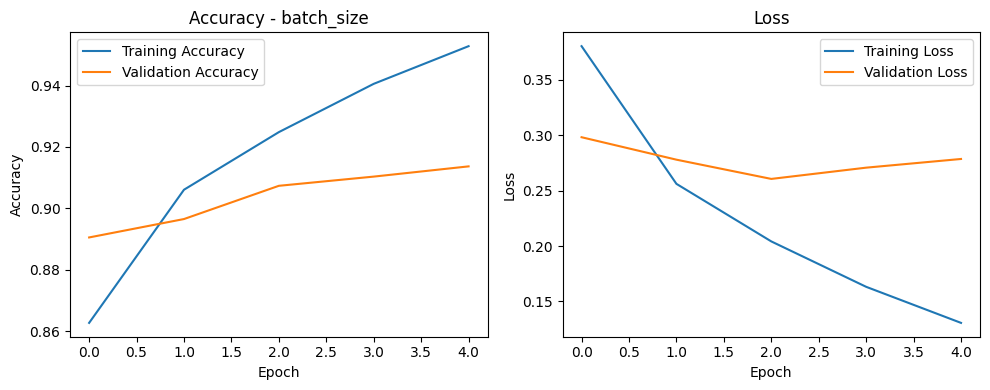


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 128, 'learning_rate': 0.001, 'experiment_group': 'batch_size', 'epochs': 5}
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 174ms/step - accuracy: 0.7909 - loss: 0.5936 - val_accuracy: 0.8882 - val_loss: 0.3188
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 177ms/step - accuracy: 0.8925 - loss: 0.3016 - val_accuracy: 0.8982 - val_loss: 0.2862
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - accuracy: 0.9092 - loss: 0.2498 - val_accuracy: 0.9060 - val_loss: 0.2674
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - accuracy: 0.9231 - loss: 0.2138 - val_accuracy: 0.9085 - val_loss: 0.2614
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 84s 172ms/step - accuracy: 0.9335 - loss: 0.1861 - val_accuracy: 0.9062 - val_loss: 0.2611
Test accuracy: 0.9061


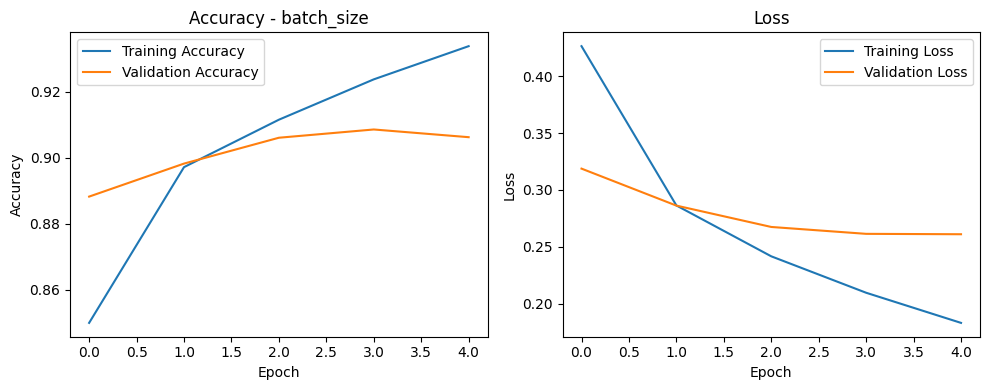

In [26]:
# Execute experiments
results = []

for config in configs:
    result = train_model(config, x_train, y_train, x_test, y_test)
    results.append(result)

    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(result['train_accuracy'], label='Training Accuracy')
    plt.plot(result['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy - {config['experiment_group']}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['history']['loss'], label='Training Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

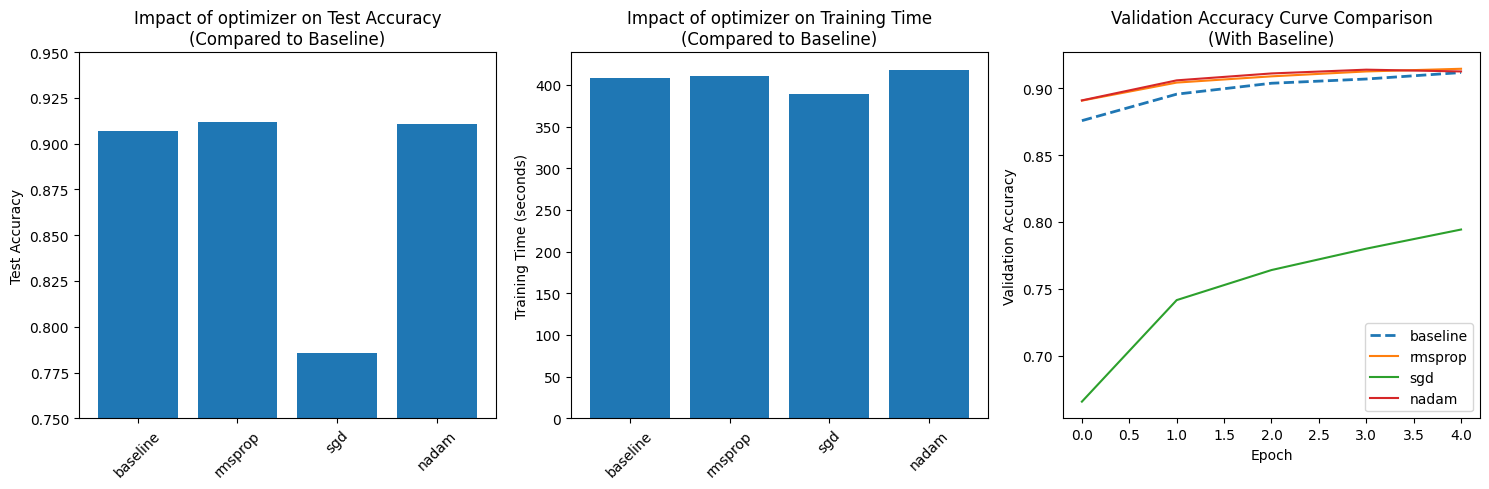

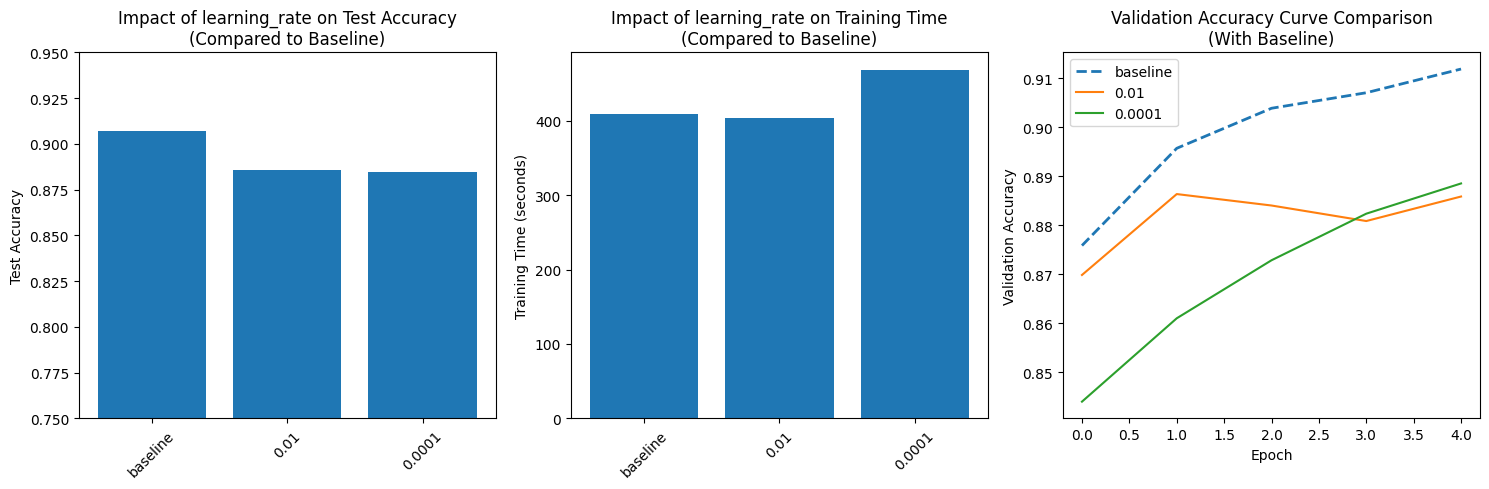

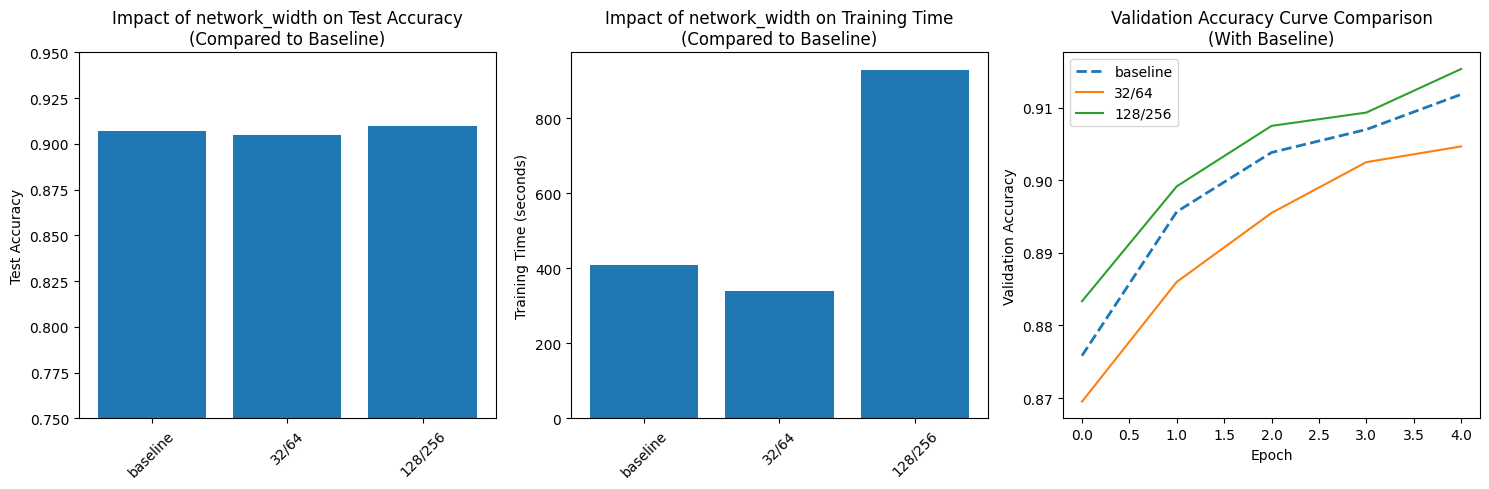

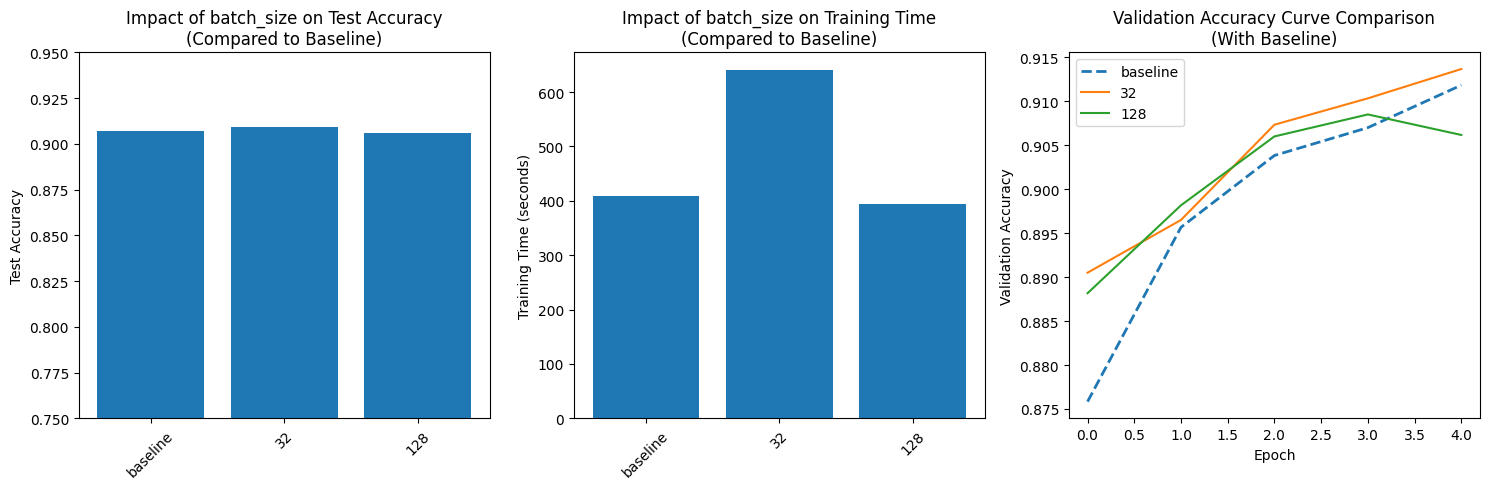

In [32]:
# Organize results by experiment group
groups = {}
for r in results:
    group = r['config']['experiment_group']
    if group not in groups:
        groups[group] = []
    groups[group].append(r)

# Get baseline result
baseline_result = [r for r in results if r['config']['experiment_group'] == 'baseline'][0]

# Create comparison charts for each experiment group
# Only process groups with multiple configurations
for group_name, group_results in groups.items():
    if len(group_results) <= 1:  # Skip groups with only one configuration
        continue

    plt.figure(figsize=(15, 5))

    # Combine baseline with current group results for comparison
    comparison_results = [baseline_result] + group_results

    # Test accuracy comparison
    plt.subplot(1, 3, 1)
    param_values = ['baseline']
    accuracies = [baseline_result['test_accuracy']]

    for r in group_results:
        if group_name == 'optimizer':
            param_values.append(str(r['config']['optimizer']))  # Convert to string
        elif group_name == 'learning_rate':
            param_values.append(str(r['config']['learning_rate']))  # Convert to string
        elif group_name == 'batch_size':
            param_values.append(str(r['config']['batch_size']))  # Convert to string
        elif group_name == 'network_width':
            param_values.append(f"{r['config']['filters']}/{r['config']['dense_units']}")


        accuracies.append(r['test_accuracy'])

    plt.bar(param_values, accuracies)
    plt.title(f"Impact of {group_name} on Test Accuracy\n(Compared to Baseline)")
    plt.ylabel("Test Accuracy")
    plt.ylim(0.75, 0.95)  # Adjust Y-axis range to highlight differences
    plt.xticks(rotation=45)  # Rotate labels for better readability

    # Training time comparison
    plt.subplot(1, 3, 2)
    train_times = [baseline_result['training_time_sec']] + [r['training_time_sec'] for r in group_results]
    plt.bar(param_values, train_times)
    plt.title(f"Impact of {group_name} on Training Time\n(Compared to Baseline)")
    plt.ylabel("Training Time (seconds)")
    plt.xticks(rotation=45)

    # Training curve comparison
    plt.subplot(1, 3, 3)
    plt.plot(baseline_result['val_accuracy'], label='baseline', linestyle='--', linewidth=2)
    for i, r in enumerate(group_results):
        label = param_values[i+1]  # Skip baseline (already added)
        plt.plot(r['val_accuracy'], label=f"{label}")
    plt.title("Validation Accuracy Curve Comparison\n(With Baseline)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [33]:
# Create results summary table
summary = []
for r in results:
    cfg = r['config']
    summary.append({
        'Experiment Group': cfg['experiment_group'],
        'Optimizer': cfg['optimizer'],
        'Learning Rate': cfg['learning_rate'],
        'Batch Size': cfg['batch_size'],
        'Filters': cfg['filters'],
        'Dense Units': cfg['dense_units'],
        'Kernel Size': cfg['kernel_size'],
        'Training Time (sec)': r['training_time_sec'],
        'Training Accuracy (final)': round(r['train_accuracy'][-1], 4),
        'Validation Accuracy (final)': round(r['val_accuracy'][-1], 4),
        'Test Accuracy': round(r['test_accuracy'], 4),
        'Overfitting Degree': round(r['train_accuracy'][-1] - r['val_accuracy'][-1], 4)
    })

summary_df = pd.DataFrame(summary)
print("\nModel Configuration Summary Table:")
display(summary_df)

# Sort by test accuracy
sorted_df = summary_df.sort_values('Test Accuracy', ascending=False)
print("\nConfigurations Sorted by Test Accuracy:")
display(sorted_df)

# Save to CSV and provide download
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"model_summary_{timestamp}.csv"
sorted_df.to_csv(filename, index=False)
files.download(filename)


Model Configuration Summary Table:


Experiment Group Optimizer  Learning Rate  Batch Size  Filters  Dense Units  \
0         baseline      adam         0.0010          64       64          128   
1        optimizer   rmsprop         0.0010          64       64          128   
2        optimizer       sgd         0.0010          64       64          128   
3        optimizer     nadam         0.0010          64       64          128   
4    learning_rate      adam         0.0100          64       64          128   
5    learning_rate      adam         0.0001          64       64          128   
6    network_width      adam         0.0010          64       32           64   
7    network_width      adam         0.0010          64      128          256   
8       batch_size      adam         0.0010          32       64          128   
9       batch_size      adam         0.0010         128       64          128   

   Kernel Size  Training Time (sec)  Training Accuracy (final)  \
0            5               408.75                     0.9424   
1            5               410.90                     0.9416   
2            5               389.55                     0.7890   
3            5               418.45                     0.9461   
4            5               403.35                     0.9231   
5            5               468.84                     0.8925   
6            5               340.07                     0.9290   
7            5               929.47                     0.9588   
8            5               640.90                     0.9529   
9            5               393.91                     0.9337   

   Validation Accuracy (final)  Test Accuracy  Overfitting Degree  
0                       0.9118         0.9069              0.0305  
1                       0.9147         0.9120              0.0270  
2                       0.7943         0.7855             -0.0054  
3                       0.9127         0.9110              0.0334  
4                       0.8858         0.8856              0.0373  
5                       0.8885         0.8847              0.0040  
6                       0.9047         0.9046              0.0244  
7                       0.9153         0.9097              0.0434  
8                       0.9137         0.9093              0.0392  
9                       0.9062         0.9061              0.0276


Configurations Sorted by Test Accuracy:


Experiment Group Optimizer  Learning Rate  Batch Size  Filters  Dense Units  \
1        optimizer   rmsprop         0.0010          64       64          128   
3        optimizer     nadam         0.0010          64       64          128   
7    network_width      adam         0.0010          64      128          256   
8       batch_size      adam         0.0010          32       64          128   
0         baseline      adam         0.0010          64       64          128   
9       batch_size      adam         0.0010         128       64          128   
6    network_width      adam         0.0010          64       32           64   
4    learning_rate      adam         0.0100          64       64          128   
5    learning_rate      adam         0.0001          64       64          128   
2        optimizer       sgd         0.0010          64       64          128   

   Kernel Size  Training Time (sec)  Training Accuracy (final)  \
1            5               410.90                     0.9416   
3            5               418.45                     0.9461   
7            5               929.47                     0.9588   
8            5               640.90                     0.9529   
0            5               408.75                     0.9424   
9            5               393.91                     0.9337   
6            5               340.07                     0.9290   
4            5               403.35                     0.9231   
5            5               468.84                     0.8925   
2            5               389.55                     0.7890   

   Validation Accuracy (final)  Test Accuracy  Overfitting Degree  
1                       0.9147         0.9120              0.0270  
3                       0.9127         0.9110              0.0334  
7                       0.9153         0.9097              0.0434  
8                       0.9137         0.9093              0.0392  
0                       0.9118         0.9069              0.0305  
9                       0.9062         0.9061              0.0276  
6                       0.9047         0.9046              0.0244  
4                       0.8858         0.8856              0.0373  
5                       0.8885         0.8847              0.0040  
2                       0.7943         0.7855             -0.0054

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

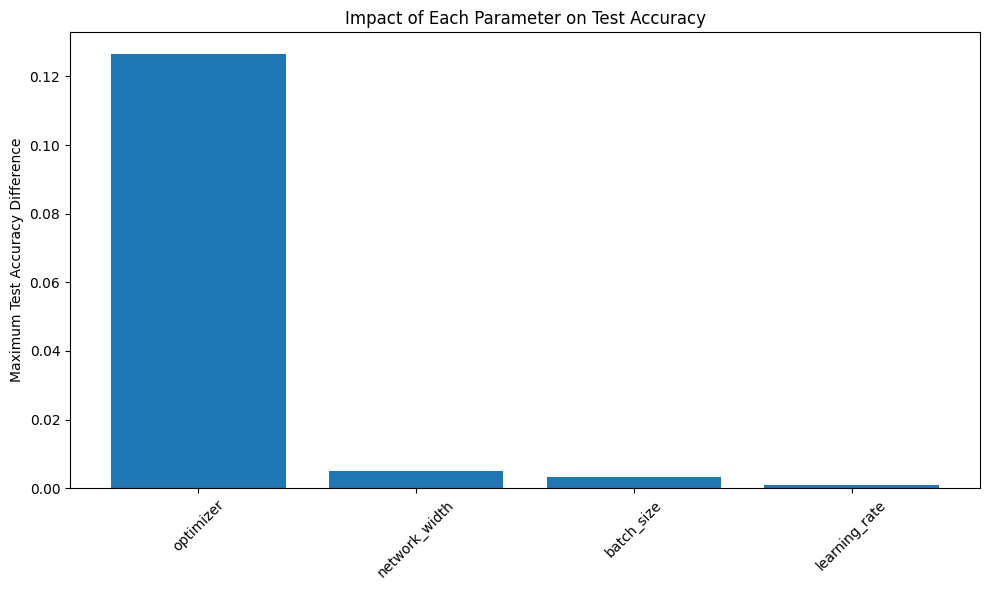

In [34]:
# Calculate and plot parameter importance
importance_data = {}

for group_name, group_results in groups.items():
    if group_name == 'baseline' or len(group_results) <= 1:
        continue

    accuracies = [r['test_accuracy'] for r in group_results]
    max_acc = max(accuracies)
    min_acc = min(accuracies)
    importance = max_acc - min_acc
    importance_data[group_name] = importance

# If there are enough groups to compare
if len(importance_data) > 1:
    plt.figure(figsize=(10, 6))
    groups = list(importance_data.keys())
    importances = list(importance_data.values())

    # Sort by importance
    sorted_indices = np.argsort(importances)[::-1]
    groups = [groups[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]

    plt.bar(groups, importances)
    plt.title("Impact of Each Parameter on Test Accuracy")
    plt.ylabel("Maximum Test Accuracy Difference")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Generating comparison plots by experiment group...


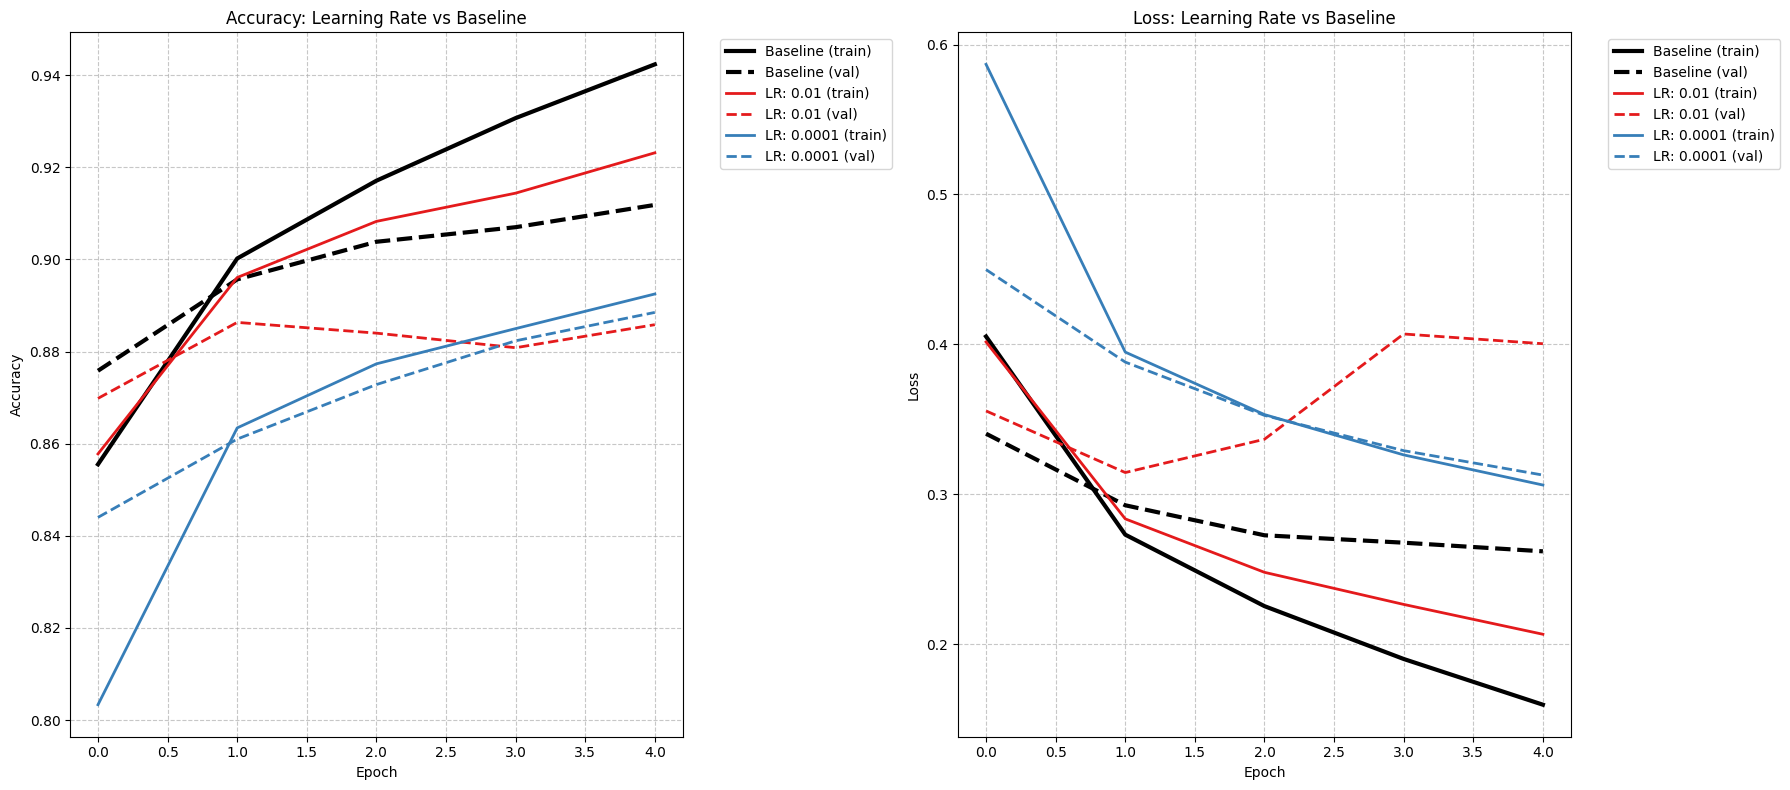

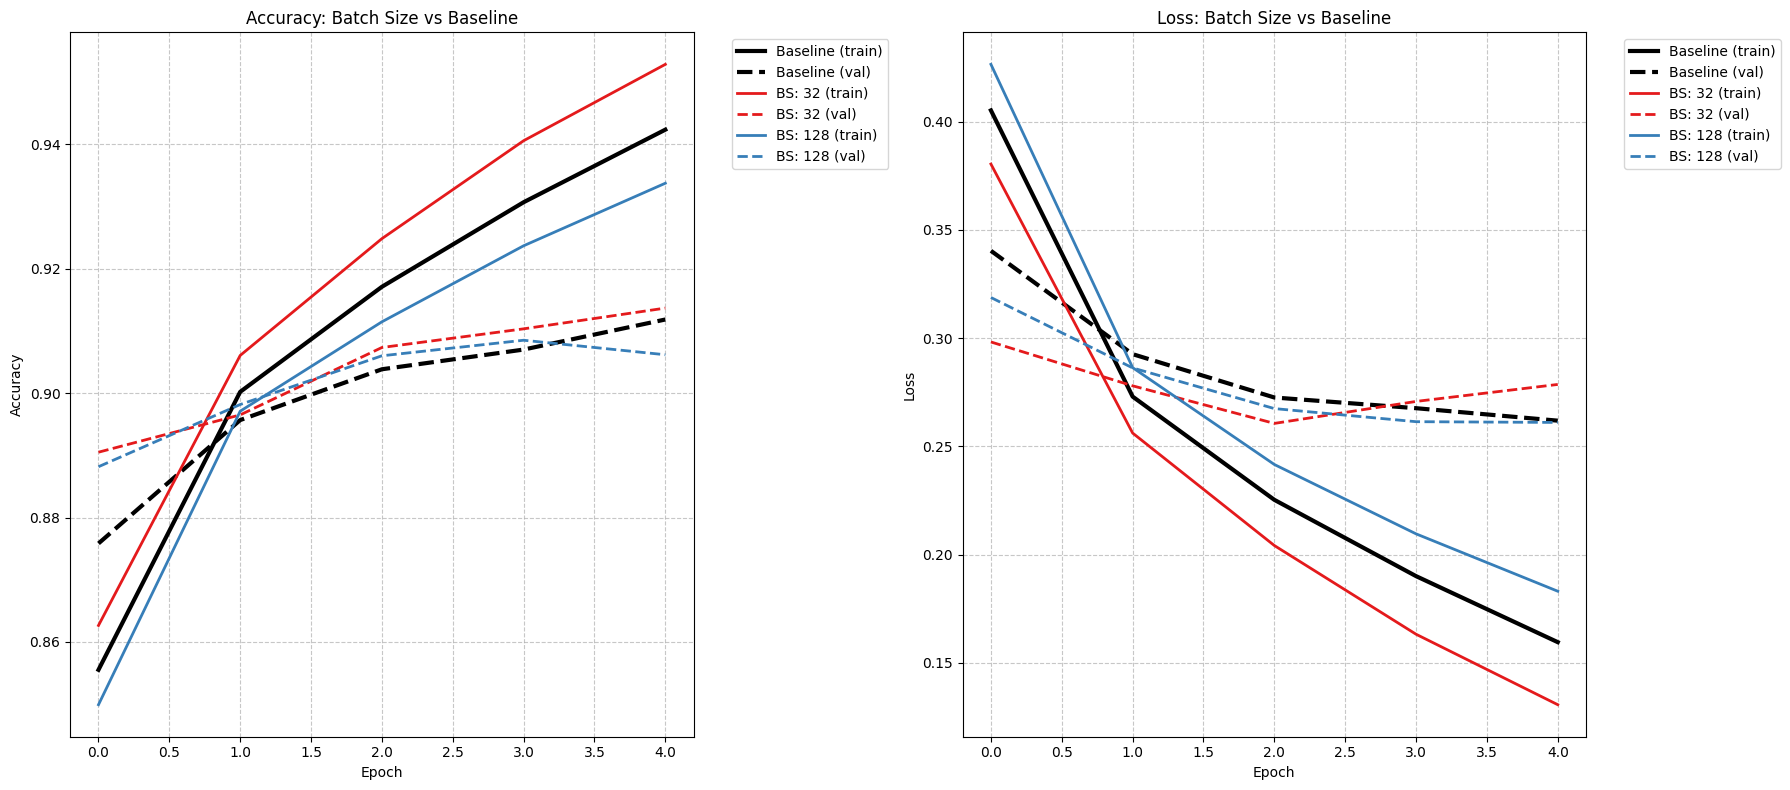

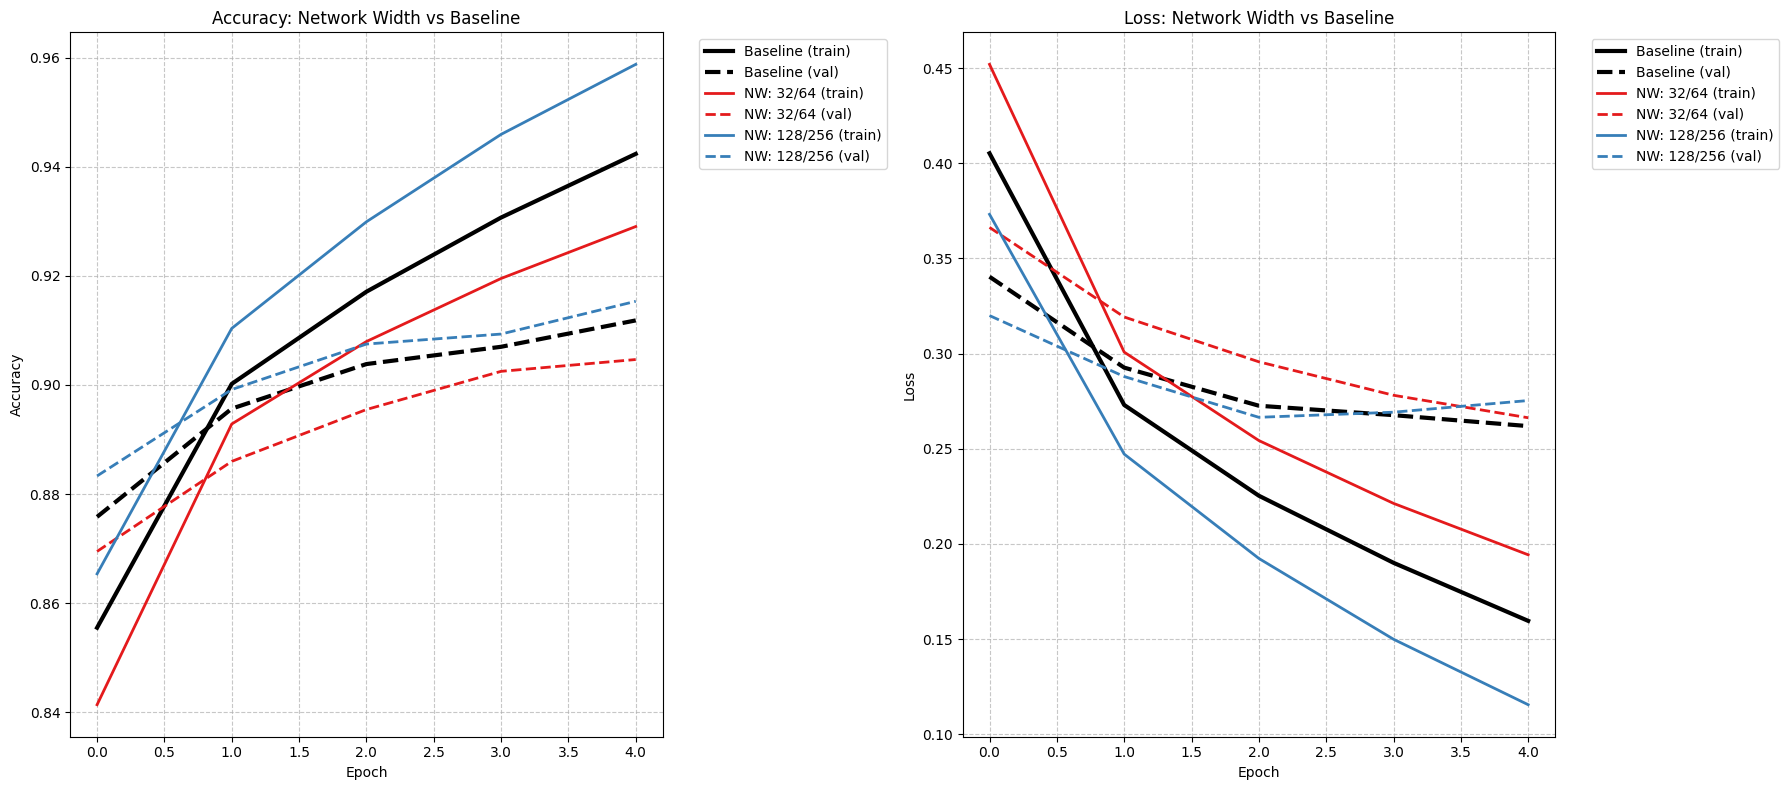

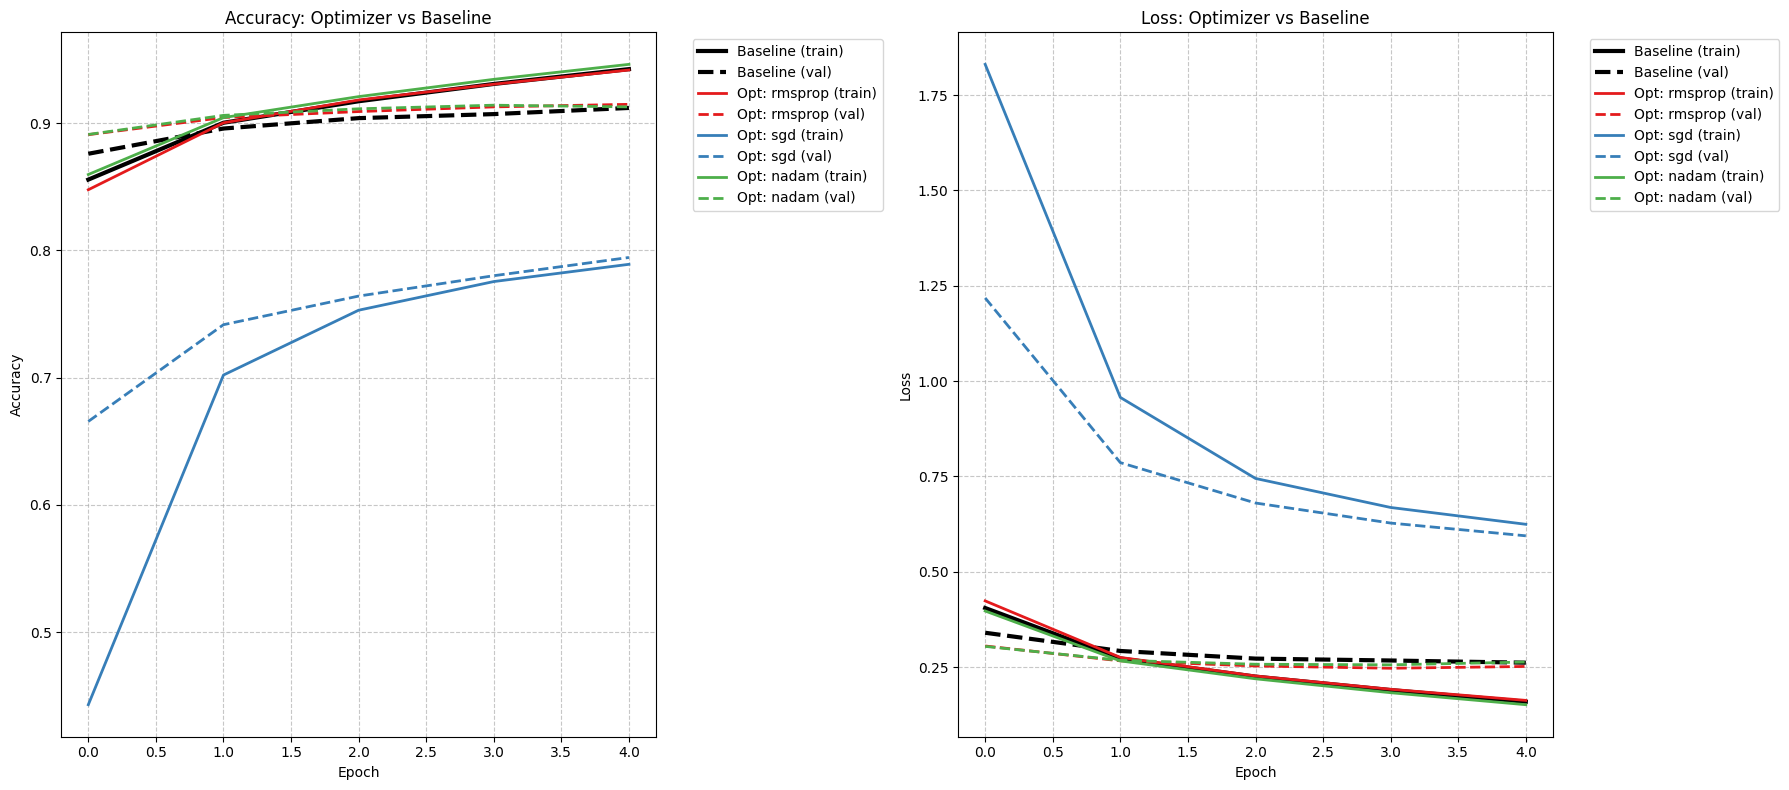

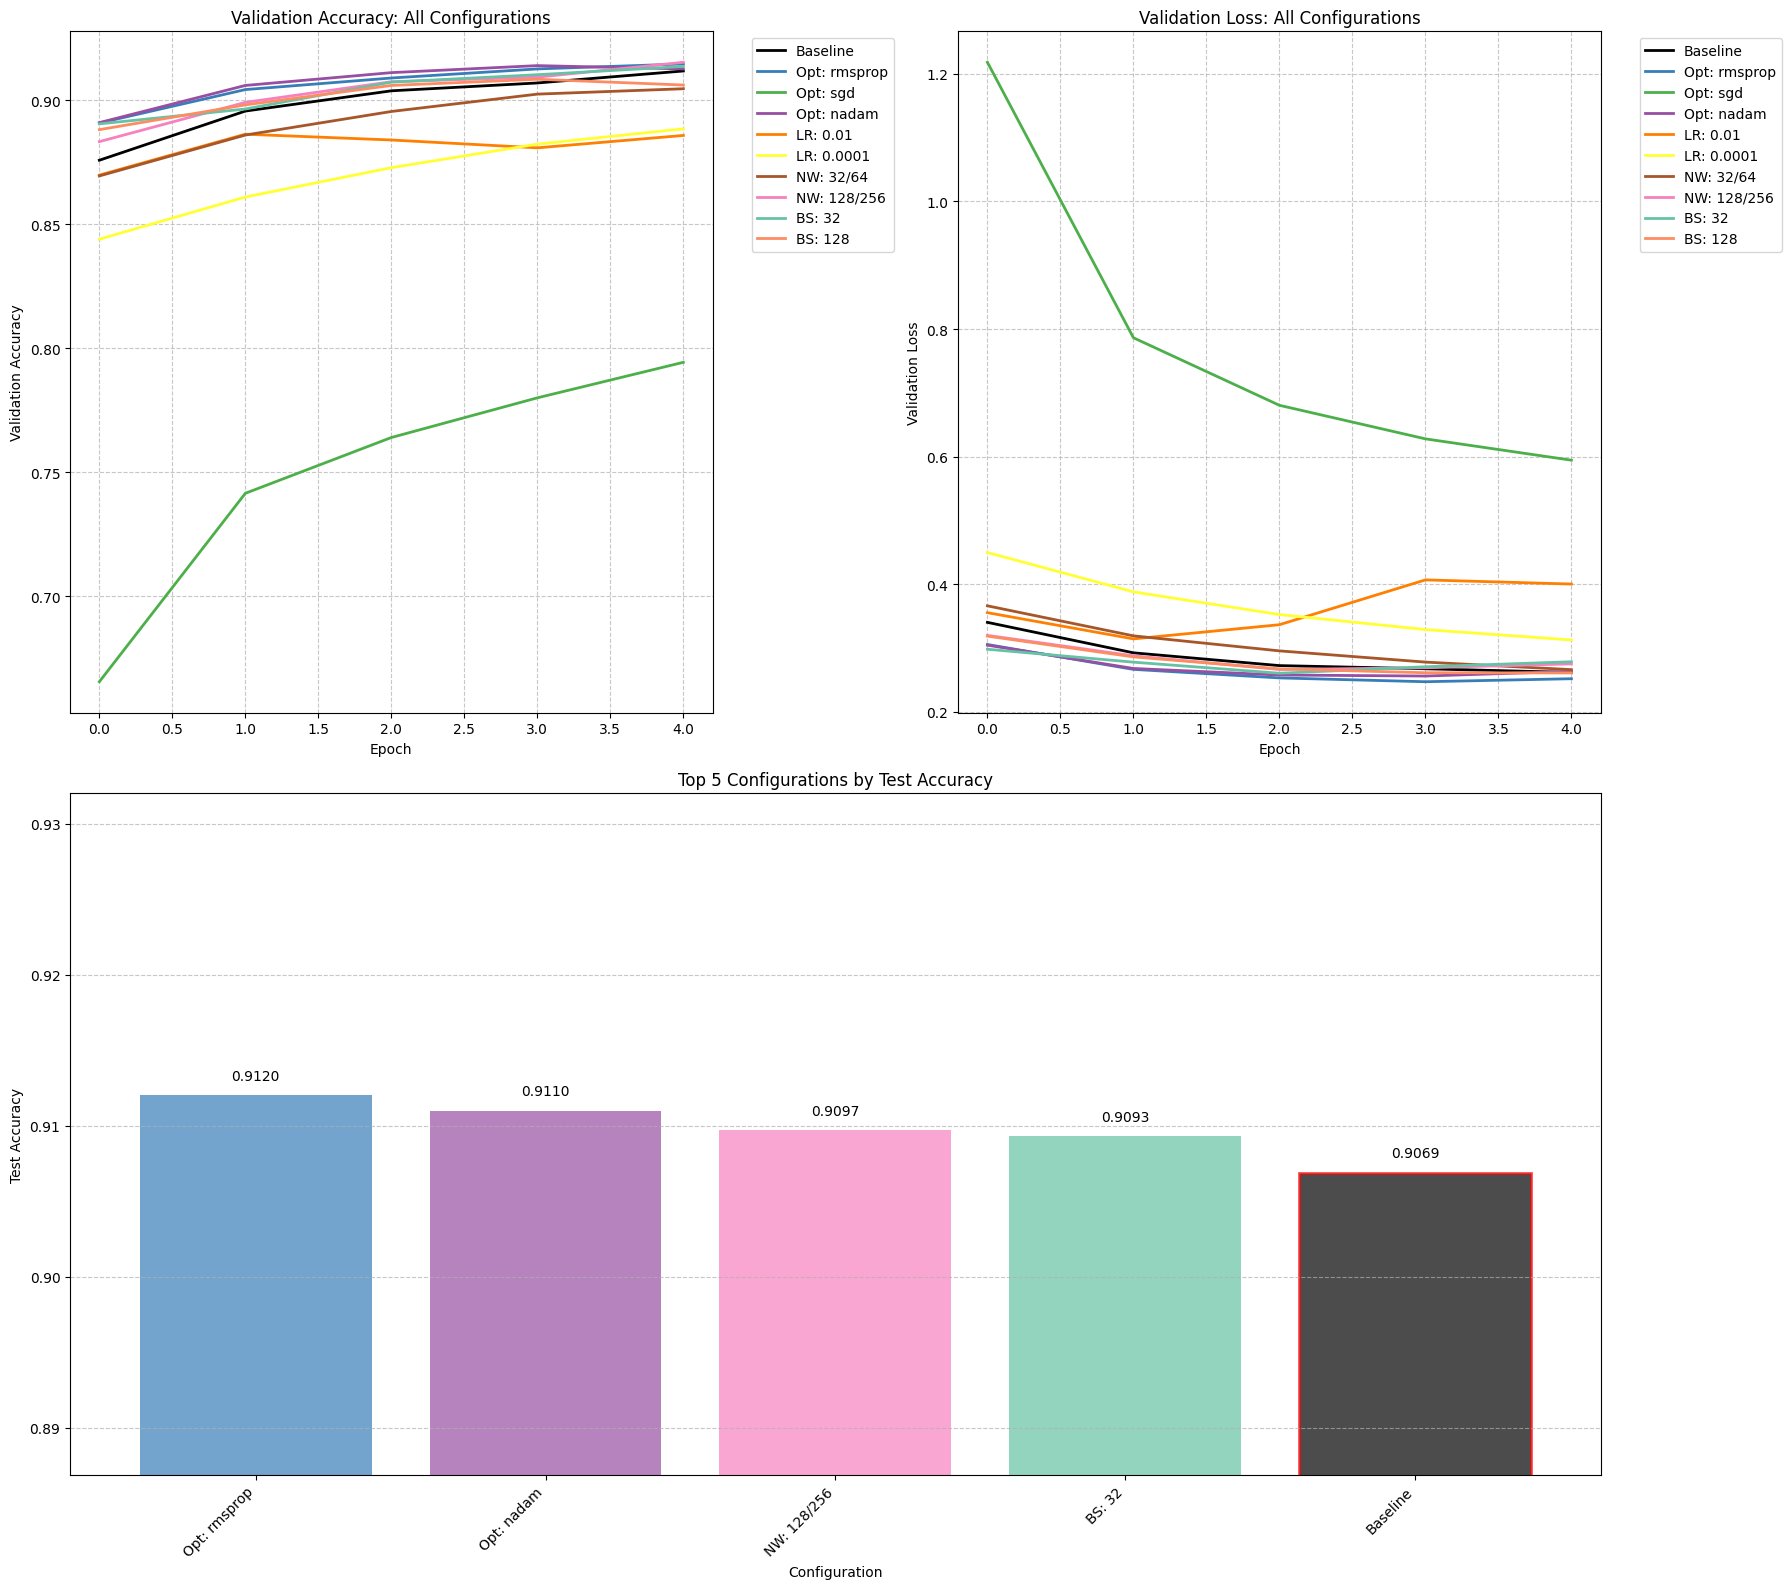


Performance Metrics (Sorted by Test Accuracy):


Group        Config  Test Acc  Best Val Acc  Best Epoch (Acc)  \
1      optimizer  Opt: rmsprop    0.9120      0.914667                 5   
3      optimizer    Opt: nadam    0.9110      0.914000                 4   
7  network_width   NW: 128/256    0.9097      0.915333                 5   
8     batch_size        BS: 32    0.9093      0.913667                 5   
0       baseline      Baseline    0.9069      0.911833                 5   
9     batch_size       BS: 128    0.9061      0.908500                 4   
6  network_width     NW: 32/64    0.9046      0.904667                 5   
4  learning_rate      LR: 0.01    0.8856      0.886333                 2   
5  learning_rate    LR: 0.0001    0.8847      0.888500                 5   
2      optimizer      Opt: sgd    0.7855      0.794333                 5   

   Best Val Loss  Best Epoch (Loss)  Overfit Degree  Train Time  
1       0.247310                  4        0.026981      410.90  
3       0.256238                  4        0.033426      418.45  
7       0.266491                  3        0.043426      929.47  
8       0.260600                  3        0.039185      640.90  
0       0.261871                  5        0.030519      408.75  
9       0.261051                  5        0.027574      393.91  
6       0.266255                  5        0.024370      340.07  
4       0.314429                  2        0.037315      403.35  
5       0.312750                  5        0.004000      468.84  
2       0.594471                  5       -0.005370      389.55

In [36]:
# Comparison of training/validation accuracy and loss curves by experiment group
print("\nGenerating comparison plots by experiment group...")

# Get unique experiment groups (excluding baseline)
unique_groups = set(r['config']['experiment_group'] for r in results)
if 'baseline' in unique_groups:
    unique_groups.remove('baseline')

# Get the baseline result for comparison
baseline_result = next((r for r in results if r['config']['experiment_group'] == 'baseline'), None)

# Define the get_config_name function
def get_config_name(cfg):
    """Generate descriptive name for each configuration"""
    if cfg['experiment_group'] == 'baseline':
        return "Baseline"
    elif cfg['experiment_group'] == 'optimizer':
        return f"Opt: {cfg['optimizer']}"
    elif cfg['experiment_group'] == 'learning_rate':
        return f"LR: {cfg['learning_rate']}"
    elif cfg['experiment_group'] == 'batch_size':
        return f"BS: {cfg['batch_size']}"
    elif cfg['experiment_group'] == 'network_width':
        return f"NW: {cfg['filters']}/{cfg['dense_units']}"
    else:
        return f"{cfg['experiment_group']}"

# For each experiment group, create a separate plot
for group_name in unique_groups:
    group_results = [r for r in results if r['config']['experiment_group'] == group_name]

    # Create 2-panel layout
    plt.figure(figsize=(18, 8))
    plt.subplots_adjust(wspace=0.3)

    # Panel 1: Training and validation accuracy with baseline comparison
    plt.subplot(1, 2, 1)

    # Plot baseline first for reference (thicker lines)
    if baseline_result:
        plt.plot(baseline_result['train_accuracy'], 'k-', linewidth=3, label="Baseline (train)")
        plt.plot(baseline_result['val_accuracy'], 'k--', linewidth=3, label="Baseline (val)")

    distinct_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']

    # Plot group results with distinct colors
    for i, r in enumerate(group_results):
        param_value = get_config_name(r['config']).replace(f"{group_name}: ", "")

        # Use color palette that provides good distinction
        color = distinct_colors[i % len(distinct_colors)]
        plt.plot(r['train_accuracy'], color=color, linestyle='-', linewidth=2,
                label=f"{param_value} (train)")
        plt.plot(r['val_accuracy'], color=color, linestyle='--', linewidth=2,
                label=f"{param_value} (val)")

    plt.title(f"Accuracy: {group_name.replace('_', ' ').title()} vs Baseline")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Panel 2: Training and validation loss with baseline comparison
    plt.subplot(1, 2, 2)

    # Plot baseline first for reference (thicker lines)
    if baseline_result:
        plt.plot(baseline_result['history']['loss'], 'k-', linewidth=3, label="Baseline (train)")
        plt.plot(baseline_result['history']['val_loss'], 'k--', linewidth=3, label="Baseline (val)")

    # Plot group results with same colors as accuracy panel
    for i, r in enumerate(group_results):
        param_value = get_config_name(r['config']).replace(f"{group_name}: ", "")

        color = distinct_colors[i % len(distinct_colors)]
        plt.plot(r['history']['loss'], color=color, linestyle='-', linewidth=2,
                label=f"{param_value} (train)")
        plt.plot(r['history']['val_loss'], color=color, linestyle='--', linewidth=2,
                label=f"{param_value} (val)")

    plt.title(f"Loss: {group_name.replace('_', ' ').title()} vs Baseline")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Create comprehensive overview plot with improved color scheme
plt.figure(figsize=(18, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Create custom color mapping for all configurations
config_colors = {}
distinct_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf',
                   '#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']
color_palette = distinct_colors

# Assign unique colors to each configuration (including baseline)
for i, r in enumerate(results):
    config_name = get_config_name(r['config'])
    if "Baseline" in config_name:
        config_colors[config_name] = 'black'
    else:
        config_colors[config_name] = distinct_colors[i % len(distinct_colors)]

# Panel 1: Validation accuracy comparison
plt.subplot(2, 2, 1)
for r in results:
    config_name = get_config_name(r['config'])
    plt.plot(r['val_accuracy'], color=config_colors[config_name],
             linestyle='-', linewidth=2, label=config_name)

plt.title("Validation Accuracy: All Configurations")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Panel 2: Validation loss comparison
plt.subplot(2, 2, 2)
for r in results:
    config_name = get_config_name(r['config'])
    plt.plot(r['history']['val_loss'], color=config_colors[config_name],
             linestyle='-', linewidth=2, label=config_name)

plt.title("Validation Loss: All Configurations")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

# Panel 3: Top configurations by test accuracy
plt.subplot(2, 1, 2)

# Extract key metrics
metrics_data = []
for r in results:
    cfg = r['config']
    best_val_acc_epoch = np.argmax(r['val_accuracy'])
    best_val_loss_epoch = np.argmin(r['history']['val_loss'])

    metrics_data.append({
        'Group': cfg['experiment_group'],
        'Config': get_config_name(cfg),
        'Test Acc': r['test_accuracy'],
        'Best Val Acc': max(r['val_accuracy']),
        'Best Epoch (Acc)': best_val_acc_epoch + 1,
        'Best Val Loss': min(r['history']['val_loss']),
        'Best Epoch (Loss)': best_val_loss_epoch + 1,
        'Overfit Degree': r['train_accuracy'][-1] - r['val_accuracy'][-1],
        'Train Time': r['training_time_sec']
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df_sorted = metrics_df.sort_values('Test Acc', ascending=False)

# Plot top configurations with their assigned colors
top_configs = metrics_df_sorted.head(5)
bar_colors = [config_colors[cfg] for cfg in top_configs['Config']]
bars = plt.bar(top_configs['Config'], top_configs['Test Acc'], color=bar_colors, alpha=0.7)

# Highlight baseline if present in top configurations
for i, config_name in enumerate(top_configs['Config']):
    if "Baseline" in config_name:
        bars[i].set_edgecolor('red')
        bars[i].set_linewidth(2)

plt.title("Top 5 Configurations by Test Accuracy")
plt.xlabel("Configuration")
plt.ylabel("Test Accuracy")
plt.ylim(max(0.85, min(top_configs['Test Acc']) - 0.02), min(0.95, max(top_configs['Test Acc']) + 0.02))
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(top_configs['Test Acc']):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.tight_layout()
plt.show()

# Display the metrics table
print("\nPerformance Metrics (Sorted by Test Accuracy):")
display(metrics_df_sorted)